In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile

# Get the path to the ZIP file
zip_file_path = '/content/gdrive/My Drive/kvasir-dataset.zip'


# Unzip the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    zip_file.extractall('/content/Endoscopy Multiclassification')


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout

In [ ]:
import os
os.path.isdir("../input") and os.path.isdir("/kaggle/working")
dataset_dir = "/content/Endoscopy Multiclassification"

In [ ]:
def get_dataCategories(dataset_dir):
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])


categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  8


,categorie,numbre of files
0,dyed-lifted-polyps,500
1,dyed-resection-margins,500
2,esophagitis,500
3,normal-cecum,500
4,normal-pylorus,500
5,normal-z-line,500
6,polyps,500
7,ulcerative-colitis,500


In [ ]:
def create_dataset(datadir, categories, img_wid, img_high):

    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                pass

    y = np.array(y)
    X = np.array(X).reshape(y.shape[0], img_wid, img_wid, 3)
    return X, y


img_wid, img_high = 100, 100
X, y = create_dataset(dataset_dir, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (4000, 100, 100, 3)
y: (4000,)


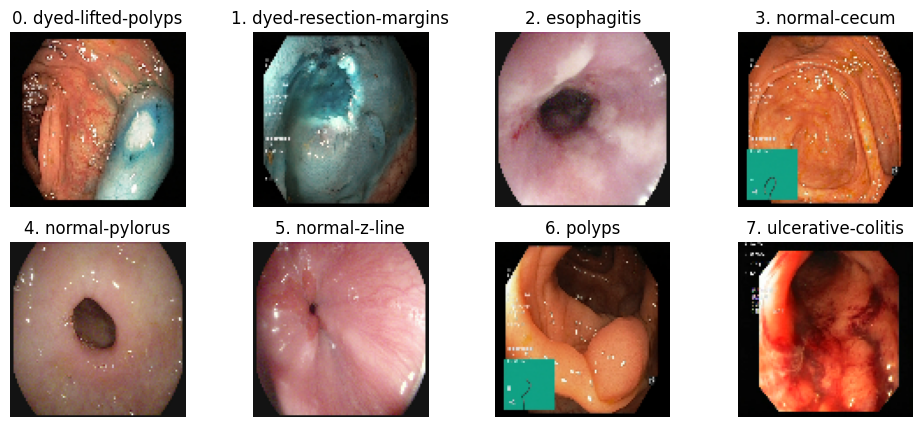

In [ ]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    # plt.imshow(X[idx][:,:,::-1])
    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()

In [ ]:
# Converting y to scaler format
Y = np.reshape(y, (len(y), 1))

# split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42
)
print(f"X_train: {X_train.shape}")
print(f"t_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (3200, 100, 100, 3)
t_train: (3200, 1)
X_test: (800, 100, 100, 3)
y_test: (800, 1)


In [ ]:
# defining training and test sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
x_test = X_test

# Dimension of the dataset
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(2240, 100, 100, 3),  y_train:(2240, 1)
x_train:(960, 100, 100, 3),  y_train:(960, 1)
x_train:(800, 100, 100, 3),  y_train:(800, 1)


In [ ]:
# One Hot Encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Verifying the dimension after one hot encoding
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(2240, 100, 100, 3),  y_train:(2240, 8)
x_train:(960, 100, 100, 3),  y_train:(960, 8)
x_train:(800, 100, 100, 3),  y_train:(800, 8)


In [ ]:
# Image Data Augmentation
train_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

val_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

test_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

# Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [ ]:
#if it has already been created and saved --> read the model
if os.path.isfile("./saved_model/vgg19_model.h5"):
    # load model
    base_model = load_model("./saved_model/vgg19_model.h5")

# if it has not already been created --> create the model and save it
else:
    base_model = VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(100, 100, 3),
        classes=y_train.shape[1],
    )
    # save model
    base_model.save("./saved_model/vgg19_model.h5")

80134624/80134624 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())

In [ ]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
Total params: 20024384 (76.39 MB)
Trainable params: 20024384 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.add(Dense(1024, activation=("relu"), input_dim=512))
model.add(Dense(512, activation=("relu")))
model.add(Dense(256, activation=("relu")))
model.add(Dropout(0.3))
model.add(Dense(128, activation=("relu")))
# model.add(Dropout(.2))
model.add(Dense(y_train.shape[1], activation=("softmax")))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [ ]:
""" Initializing the hyperparameters """

# Initialise no. of training samples for each batch
batch_size = 128

# No. of iterations
epochs = 30

# Learning rate
learn_rate = 0.001

# Using Gradient Descent
sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)

# Using adam optimizer
# adam = Adam( learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compiling the model
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
# Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor="val_acc", factor=0.01, patience=3, min_lr=1e-5)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Your existing code

# Add the model.compile line to specify metrics
if os.path.isfile("./saved_model/model.h5"):
    # Load model
    model = load_model("./saved_model/model.h5")

    # Specify metrics for the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'val_accuracy'])

    # if model history has been saved --> read history
    if os.path.isfile("./saved_model/model_history.npy"):
        # Read history
        history = np.load("./saved_model/model_history.npy", allow_pickle=True).item()
    else:
        history = None
else:
    # Your training code
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        steps_per_epoch=x_train.shape[0] // batch_size,
        validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
        callbacks=[lrr],
        verbose=1,
    )
    history = history.history

    # Save model
    np.save("./saved_model/model_history.npy", history)
    model.save("./saved_model/model.h5")


Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 2.9454 - accuracy: 0.1250  

17/17 [==============================] - 1423s 84s/step - loss: 2.9454 - accuracy: 0.1250 - val_loss: 2.0652 - val_accuracy: 0.1323 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 2.0415 - accuracy: 0.1879  

17/17 [==============================] - 1464s 87s/step - loss: 2.0415 - accuracy: 0.1879 - val_loss: 1.9971 - val_accuracy: 0.2885 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 1.9717 - accuracy: 0.2183  

17/17 [==============================] - 1461s 87s/step - loss: 1.9717 - accuracy: 0.2183 - val_loss: 1.8673 - val_accuracy: 0.2417 - lr: 0.0010
Epoch 4/30
17/17 [==============================] - ETA: 0s - loss: 1.5801 - accuracy: 0.3379  

17/17 [==============================] - 1362s 80s/step - loss: 1.5801 - accuracy: 0.3379 - val_loss: 1.6516 - val_accuracy: 0.3688 - lr: 0.0010
Epoch 5/30
17/17 [==============================] - ETA: 0s - loss: 1.3453 - accuracy: 0.4165  

17/17 [==============================] - 1356s 80s/step - loss: 1.3453 - accuracy: 0.4165 - val_loss: 1.3194 - val_accuracy: 0.4187 - lr: 0.0010
Epoch 6/30
17/17 [==============================] - ETA: 0s - loss: 1.1335 - accuracy: 0.4884  

17/17 [==============================] - 1433s 85s/step - loss: 1.1335 - accuracy: 0.4884 - val_loss: 1.2444 - val_accuracy: 0.4625 - lr: 0.0010
Epoch 7/30
 6/17 [=========>....................] - ETA: 13:41 - loss: 1.0979 - accuracy: 0.5114

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", round(score[0], 3))
print("Test accuracy:", round(score[1], 3))

In [ ]:
score

In [ ]:
history.keys()

In [ ]:
import matplotlib.pyplot as plt2
plt2.figure(figsize=(12, 6))
plt2.plot(history['val_accuracy'])
plt2.plot(history['accuracy'])
plt2.title('model accuracy')
plt2.ylabel('accuracy')
plt2.xlabel('epoch')
plt2.legend(['train', 'val'], loc='upper left')
plt2.show()

In [ ]:
plt2.plot(history['accuracy'])
plt2.title('model accuracy')
plt2.ylabel('accuracy')
plt2.xlabel('epoch')
plt2.legend(['train', 'val'], loc='upper left')
plt2.show()

In [ ]:
def cm_plt(ax, cm, classes, cmap, title, normalize):
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
           ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax

# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
         cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )

In [ ]:
# Making the predictions
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
# get confusion matrix
confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(confuision_mat, classes=categories, fig_size=(20, 7))

In [ ]:
def predict_categorie_img(img, model, categories):
    try:
        img = img[None, :, :, :]
    except:
        raise TypeError("test image dimension != 3")
    predict = model.predict(img)
    idx_cat = np.argmax(predict, axis=1)[0]
    return idx_cat, categories[idx_cat]

plt.figure(figsize=(20, 8))
for i in range(10):
    idx = np.random.randint(len(y))
    img = X[idx]
    pred_class = predict_categorie_img(img, model, categories)
    true_class = y[idx], categories[y[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img[:, :, ::-1])
    plt.title(f"Pred:[{pred_class}]\nTrue:[{true_class}]")
    plt.axis("off")
plt.show()